## Import Python Modules

In [19]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

## Create Model

In [20]:
%matplotlib inline
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

def create_model():
    input_shape = (105, 105, 1)
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    #build convnet to use in each siamese 'leg'
    convnet = Sequential()
    convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                       kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
    convnet.add(MaxPooling2D())
    convnet.add(Conv2D(128,(7,7),activation='relu',
                       kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
    convnet.add(MaxPooling2D())
    convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
    convnet.add(MaxPooling2D())
    convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
    convnet.add(Flatten())
    convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

    #call the convnet Sequential model on each of the input tensors so params will be shared
    encoded_l = convnet(left_input)
    encoded_r = convnet(right_input)
    #layer to merge two encoded inputs with the l1 distance between them
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    #call this layer on list of two input tensors.
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    optimizer = Adam(0.00006)
    #//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
    siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

    siamese_net.count_params()
    return siamese_net

## Data 
The data is pickled as an N_classes x n_examples x width x height array, and there is an accompanyng dictionary to specify which indexes belong to which languages.

In [21]:
def load_data():
    PATH = "./" #CHANGE THIS - path where the pickled data is stored


    with open(os.path.join(PATH, "sig_data_train.pickle"), "rb") as f:
        (X,c) = pickle.load(f)

    with open(os.path.join(PATH, "val.pickle"), "rb") as f:
        (Xval,cval) = pickle.load(f)

    print("X's length {}".format(len(X)))

    # print("training alphabets")  
    # print("X's shape {}".format(X.shape))
    # print("training alphabets")
    # print(c.keys())
    print("validation alphabets:")
    print(cval.keys())

In [22]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["sig_data_train", "val"]):
        self.data = {}
        self.author_dict = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,a) = pickle.load(f)
                self.data[name] = X
                self.author_dict[name] = a

    def get_batch(self,batch_size,s="sig_data_train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        author_dict = self.author_dict[s]
        sig_examples = len(X)
        author_examples = len(author_dict)
        w,h = X[0].shape

        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.ones((batch_size,))
        targets[batch_size//2:] = 0
        
        i = 0
        #pick images from same author for the first half input
        while i < batch_size // 2:
            author_id = rng.choice(list(author_dict))
            num_of_index = len(author_dict[author_id])
            if num_of_index <= 1:
                continue
            else:                
                idx_1 = rng.randint(0, num_of_index)
                idx_2 = rng.randint(0, num_of_index)
                pairs[0][i,:,:,:] = X[author_dict[author_id][idx_1]].reshape(w, h, 1)
                pairs[1][i,:,:,:] = X[author_dict[author_id][idx_2]].reshape(w, h, 1)
                i += 1

        #pick images from differnt author for the second half input
        while i < batch_size:
            author_id_1 = rng.choice(list(author_dict))
            author_id_2 = rng.choice(list(author_dict))
            if author_id_1 == author_id_2:
                continue
            else:
                num_of_index_1 = len(author_dict[author_id_1])
                num_of_index_2 = len(author_dict[author_id_2])
                idx_1 = rng.randint(0, num_of_index_1)
                idx_2 = rng.randint(0, num_of_index_2)
                pairs[0][i,:,:,:] = X[author_dict[author_id_1][idx_1]].reshape(w, h, 1)
                pairs[1][i,:,:,:] = X[author_dict[author_id_2][idx_2]].reshape(w, h, 1)
                i += 1
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot_ori(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct
    
    def test_oneshot(self,model,size,s="sig_data_train"):
        inputs, targets = self.get_batch(size,s)
        #inputs, targets = shuffle(inputs, targets)
        probs = model.predict(inputs)
        probs = probs > 0.5
        probs = probs.reshape(1,size)
        corrects = np.sum(probs == targets)        
        percent_correct = (100.0 * corrects / size)
        print("Got an average of {}%  one-shot learning accuracy".format(percent_correct))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size),
                            
                             )
    
    


In [23]:

def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task_original(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

def plot_batch_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(8)
    
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)

    ax2.matshow(pairs[1][0].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax2.get_yaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    
    ax3.matshow(pairs[0][4].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax3.get_yaxis().set_visible(False)
    ax3.get_xaxis().set_visible(False)

    ax4.matshow(pairs[1][4].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax4.get_yaxis().set_visible(False)
    ax4.get_xaxis().set_visible(False)

    ax5.matshow(pairs[0][5].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax5.get_yaxis().set_visible(False)
    ax5.get_xaxis().set_visible(False)

    ax6.matshow(pairs[1][5].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax6.get_yaxis().set_visible(False)
    ax6.get_xaxis().set_visible(False)

    
    ax7.matshow(pairs[0][9].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax7.get_yaxis().set_visible(False)
    ax7.get_xaxis().set_visible(False)

    ax8.matshow(pairs[1][9].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax8.get_yaxis().set_visible(False)
    ax8.get_xaxis().set_visible(False)

    plt.xticks([])
    plt.yticks([])
    plt.show()


In [37]:
def train_model():
    num_iterations = 10000
    evaluate_every = 100 # interval for evaluating on one-shot tasks
    batch_size = 32
    n_val = 300 #how mahy one-shot tasks to validate on?
    best = -1
    PATH = "."
    loader = Siamese_Loader(PATH)
    siamese_net = create_model()
    weights_path = os.path.join(PATH, "weights")
    print("Start training at: {}".format(datetime.datetime.now()))
    
    costs = []
    val_accs = []
    for i in range(0, num_iterations):
        (inputs,targets)=loader.get_batch(batch_size)
        loss=siamese_net.train_on_batch(inputs,targets)
        print ("Cost after iteration %i: %f" %(i, loss))
        if i % evaluate_every == 0:
            val_acc = loader.test_oneshot(siamese_net,n_val,"val")
            costs.append(loss)
            val_accs.append(val_acc)
            if val_acc >= best:
                siamese_net.save(weights_path)
                best=val_acc
    print("End training at: {}".format(datetime.datetime.now()))
    
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per {})'.format(evaluate_every))
    plt.show()
    
    plt.plot(np.squeeze(val_accs))
    plt.ylabel('validation accuracy')
    plt.xlabel('iterations (per {})'.format(evaluate_every))
    plt.show()

## Test Loader

In [27]:
#Instantiate the class
loader = Siamese_Loader(PATH)
pairs,target = loader.get_batch(10)
print("No of pairs0 {}".format(len(pairs[0])))
print("No of pairs1 {}".format(len(pairs[1])))
print("target {}".format(target))

NameError: name 'PATH' is not defined

## Test Plot

In [26]:
#example of a one-shot learning task
# pairs, targets = loader.make_oneshot_task(20,"train","Japanese_(katakana)")
# plot_oneshot_task(pairs)

pairs, targets = loader.get_batch(10)
plot_batch_task(pairs)

NameError: name 'loader' is not defined

## Train Model

loading data from ./sig_data_train.pickle
loading data from ./val.pickle
Start training at: 2018-09-28 21:31:39.328156
Cost after iteration 0: 4.519413
Got an average of 55.333333333333336%  one-shot learning accuracy
Cost after iteration 1: 4.432236
Cost after iteration 2: 4.414537
Cost after iteration 3: 4.324552
Cost after iteration 4: 4.295227
Cost after iteration 5: 4.344651
Cost after iteration 6: 4.297922
Cost after iteration 7: 4.289093
Cost after iteration 8: 4.242183
Cost after iteration 9: 4.258181
Cost after iteration 10: 4.204634
Cost after iteration 11: 4.179155
Cost after iteration 12: 4.102225
Cost after iteration 13: 4.058324
Cost after iteration 14: 4.086591
Cost after iteration 15: 4.044552
Cost after iteration 16: 4.096490
Cost after iteration 17: 4.023935
Cost after iteration 18: 4.067760
Cost after iteration 19: 3.996163
Cost after iteration 20: 3.943245
Cost after iteration 21: 3.970404
Cost after iteration 22: 3.951716
Cost after iteration 23: 3.948622
Cost afte

Cost after iteration 229: 1.926024
Cost after iteration 230: 2.003994
Cost after iteration 231: 1.931164
Cost after iteration 232: 2.174635
Cost after iteration 233: 1.983588
Cost after iteration 234: 2.031982
Cost after iteration 235: 2.086922
Cost after iteration 236: 1.904015
Cost after iteration 237: 1.975472
Cost after iteration 238: 1.937784
Cost after iteration 239: 1.941180
Cost after iteration 240: 1.858479
Cost after iteration 241: 1.963859
Cost after iteration 242: 1.871623
Cost after iteration 243: 1.867331
Cost after iteration 244: 1.938875
Cost after iteration 245: 1.878884
Cost after iteration 246: 1.890875
Cost after iteration 247: 1.928385
Cost after iteration 248: 1.868914
Cost after iteration 249: 1.910319
Cost after iteration 250: 1.820226
Cost after iteration 251: 2.004613
Cost after iteration 252: 2.082955
Cost after iteration 253: 1.895901
Cost after iteration 254: 1.970676
Cost after iteration 255: 1.878903
Cost after iteration 256: 1.909028
Cost after iteration

Cost after iteration 460: 1.344281
Cost after iteration 461: 1.428839
Cost after iteration 462: 1.367597
Cost after iteration 463: 1.599084
Cost after iteration 464: 1.315607
Cost after iteration 465: 1.382523
Cost after iteration 466: 1.357647
Cost after iteration 467: 1.422629
Cost after iteration 468: 1.320718
Cost after iteration 469: 1.549765
Cost after iteration 470: 1.438066
Cost after iteration 471: 1.406792
Cost after iteration 472: 1.380854
Cost after iteration 473: 1.323567
Cost after iteration 474: 1.336731
Cost after iteration 475: 1.347009
Cost after iteration 476: 1.382652
Cost after iteration 477: 1.308928
Cost after iteration 478: 1.362653
Cost after iteration 479: 1.364840
Cost after iteration 480: 1.360505
Cost after iteration 481: 1.372722
Cost after iteration 482: 1.465723
Cost after iteration 483: 1.373987
Cost after iteration 484: 1.358266
Cost after iteration 485: 1.345083
Cost after iteration 486: 1.323365
Cost after iteration 487: 1.285801
Cost after iteration

Cost after iteration 691: 1.079865
Cost after iteration 692: 1.167447
Cost after iteration 693: 1.081699
Cost after iteration 694: 1.031255
Cost after iteration 695: 1.060932
Cost after iteration 696: 1.088342
Cost after iteration 697: 1.152418
Cost after iteration 698: 1.071567
Cost after iteration 699: 1.054449
Cost after iteration 700: 1.040352
Got an average of 77.0%  one-shot learning accuracy
Cost after iteration 701: 1.234082
Cost after iteration 702: 1.074165
Cost after iteration 703: 1.110887
Cost after iteration 704: 1.070279
Cost after iteration 705: 1.084380
Cost after iteration 706: 1.053161
Cost after iteration 707: 1.113126
Cost after iteration 708: 1.039219
Cost after iteration 709: 1.199047
Cost after iteration 710: 1.170116
Cost after iteration 711: 1.065719
Cost after iteration 712: 1.063901
Cost after iteration 713: 1.202330
Cost after iteration 714: 1.049692
Cost after iteration 715: 1.219178
Cost after iteration 716: 1.079765
Cost after iteration 717: 1.024446
Cos

Cost after iteration 921: 0.872129
Cost after iteration 922: 0.911128
Cost after iteration 923: 0.881950
Cost after iteration 924: 0.840115
Cost after iteration 925: 1.009151
Cost after iteration 926: 0.863255
Cost after iteration 927: 0.883420
Cost after iteration 928: 0.862451
Cost after iteration 929: 0.869233
Cost after iteration 930: 0.895336
Cost after iteration 931: 0.965723
Cost after iteration 932: 0.903268
Cost after iteration 933: 0.916947
Cost after iteration 934: 0.835884
Cost after iteration 935: 0.843632
Cost after iteration 936: 0.922513
Cost after iteration 937: 0.877651
Cost after iteration 938: 0.895439
Cost after iteration 939: 0.865960
Cost after iteration 940: 0.882496
Cost after iteration 941: 0.876839
Cost after iteration 942: 0.866795
Cost after iteration 943: 0.887747
Cost after iteration 944: 0.901912
Cost after iteration 945: 0.916312
Cost after iteration 946: 0.877517
Cost after iteration 947: 0.851003
Cost after iteration 948: 0.954634
Cost after iteration

Cost after iteration 1148: 0.723561
Cost after iteration 1149: 0.811586
Cost after iteration 1150: 0.754015
Cost after iteration 1151: 0.716363
Cost after iteration 1152: 0.793550
Cost after iteration 1153: 0.742902
Cost after iteration 1154: 0.852921
Cost after iteration 1155: 0.784280
Cost after iteration 1156: 0.782930
Cost after iteration 1157: 0.745713
Cost after iteration 1158: 0.843040
Cost after iteration 1159: 0.769068
Cost after iteration 1160: 0.775983
Cost after iteration 1161: 0.772086
Cost after iteration 1162: 0.720231
Cost after iteration 1163: 0.800880
Cost after iteration 1164: 0.803463
Cost after iteration 1165: 0.719307
Cost after iteration 1166: 0.711785
Cost after iteration 1167: 0.767488
Cost after iteration 1168: 0.894523
Cost after iteration 1169: 0.776981
Cost after iteration 1170: 0.751000
Cost after iteration 1171: 0.759580
Cost after iteration 1172: 0.737559
Cost after iteration 1173: 0.810238
Cost after iteration 1174: 0.861325
Cost after iteration 1175: 0

Cost after iteration 1372: 0.647506
Cost after iteration 1373: 0.774691
Cost after iteration 1374: 0.686999
Cost after iteration 1375: 0.635581
Cost after iteration 1376: 0.638641
Cost after iteration 1377: 0.627764
Cost after iteration 1378: 0.651003
Cost after iteration 1379: 0.626795
Cost after iteration 1380: 0.714544
Cost after iteration 1381: 0.650916
Cost after iteration 1382: 0.618927
Cost after iteration 1383: 0.720744
Cost after iteration 1384: 0.657923
Cost after iteration 1385: 0.760167
Cost after iteration 1386: 0.615599
Cost after iteration 1387: 0.672065
Cost after iteration 1388: 0.645070
Cost after iteration 1389: 0.646456
Cost after iteration 1390: 0.633660
Cost after iteration 1391: 0.701111
Cost after iteration 1392: 0.765539
Cost after iteration 1393: 0.600637
Cost after iteration 1394: 0.689495
Cost after iteration 1395: 0.673658
Cost after iteration 1396: 0.657406
Cost after iteration 1397: 0.641778
Cost after iteration 1398: 0.647432
Cost after iteration 1399: 0

Cost after iteration 1597: 0.555751
Cost after iteration 1598: 0.591320
Cost after iteration 1599: 0.583354
Cost after iteration 1600: 0.553276
Got an average of 80.66666666666667%  one-shot learning accuracy
Cost after iteration 1601: 0.539650
Cost after iteration 1602: 0.528151
Cost after iteration 1603: 0.551251
Cost after iteration 1604: 0.555075
Cost after iteration 1605: 0.555337
Cost after iteration 1606: 0.557305
Cost after iteration 1607: 0.562530
Cost after iteration 1608: 0.568216
Cost after iteration 1609: 0.573750
Cost after iteration 1610: 0.568941
Cost after iteration 1611: 0.542594
Cost after iteration 1612: 0.581893
Cost after iteration 1613: 0.538619
Cost after iteration 1614: 0.546390
Cost after iteration 1615: 0.539484
Cost after iteration 1616: 0.559836
Cost after iteration 1617: 0.533843
Cost after iteration 1618: 0.533650
Cost after iteration 1619: 0.508371
Cost after iteration 1620: 0.540691
Cost after iteration 1621: 0.577506
Cost after iteration 1622: 0.530210

Cost after iteration 1820: 0.473165
Cost after iteration 1821: 0.506011
Cost after iteration 1822: 0.466499
Cost after iteration 1823: 0.505509
Cost after iteration 1824: 0.511103
Cost after iteration 1825: 0.470461
Cost after iteration 1826: 0.501017
Cost after iteration 1827: 0.508888
Cost after iteration 1828: 0.496598
Cost after iteration 1829: 0.475464
Cost after iteration 1830: 0.525773
Cost after iteration 1831: 0.507906
Cost after iteration 1832: 0.688570
Cost after iteration 1833: 0.498006
Cost after iteration 1834: 0.468950
Cost after iteration 1835: 0.491264
Cost after iteration 1836: 0.509138
Cost after iteration 1837: 0.483163
Cost after iteration 1838: 0.533173
Cost after iteration 1839: 0.504567
Cost after iteration 1840: 0.442772
Cost after iteration 1841: 0.511958
Cost after iteration 1842: 0.458839
Cost after iteration 1843: 0.488383
Cost after iteration 1844: 0.472896
Cost after iteration 1845: 0.523243
Cost after iteration 1846: 0.501753
Cost after iteration 1847: 0

Cost after iteration 2045: 0.432647
Cost after iteration 2046: 0.464065
Cost after iteration 2047: 0.470162
Cost after iteration 2048: 0.403739
Cost after iteration 2049: 0.463448
Cost after iteration 2050: 0.520226
Cost after iteration 2051: 0.412159
Cost after iteration 2052: 0.481517
Cost after iteration 2053: 0.413126
Cost after iteration 2054: 0.430057
Cost after iteration 2055: 0.481494
Cost after iteration 2056: 0.427164
Cost after iteration 2057: 0.402997
Cost after iteration 2058: 0.457630
Cost after iteration 2059: 0.403976
Cost after iteration 2060: 0.506293
Cost after iteration 2061: 0.423990
Cost after iteration 2062: 0.422804
Cost after iteration 2063: 0.448144
Cost after iteration 2064: 0.417890
Cost after iteration 2065: 0.427868
Cost after iteration 2066: 0.430346
Cost after iteration 2067: 0.598348
Cost after iteration 2068: 0.418663
Cost after iteration 2069: 0.401313
Cost after iteration 2070: 0.426540
Cost after iteration 2071: 0.489573
Cost after iteration 2072: 0

Cost after iteration 2269: 0.424130
Cost after iteration 2270: 0.388332
Cost after iteration 2271: 0.398720
Cost after iteration 2272: 0.378891
Cost after iteration 2273: 0.428801
Cost after iteration 2274: 0.348051
Cost after iteration 2275: 0.381288
Cost after iteration 2276: 0.475363
Cost after iteration 2277: 0.397532
Cost after iteration 2278: 0.382678
Cost after iteration 2279: 0.371484
Cost after iteration 2280: 0.339261
Cost after iteration 2281: 0.374452
Cost after iteration 2282: 0.359230
Cost after iteration 2283: 0.418970
Cost after iteration 2284: 0.345822
Cost after iteration 2285: 0.384949
Cost after iteration 2286: 0.376968
Cost after iteration 2287: 0.386906
Cost after iteration 2288: 0.355191
Cost after iteration 2289: 0.398595
Cost after iteration 2290: 0.370328
Cost after iteration 2291: 0.365409
Cost after iteration 2292: 0.369275
Cost after iteration 2293: 0.394573
Cost after iteration 2294: 0.357166
Cost after iteration 2295: 0.341758
Cost after iteration 2296: 0

Cost after iteration 2493: 0.360279
Cost after iteration 2494: 0.342744
Cost after iteration 2495: 0.329400
Cost after iteration 2496: 0.313022
Cost after iteration 2497: 0.321755
Cost after iteration 2498: 0.344129
Cost after iteration 2499: 0.316557
Cost after iteration 2500: 0.344136
Got an average of 81.0%  one-shot learning accuracy
Cost after iteration 2501: 0.367097
Cost after iteration 2502: 0.376421
Cost after iteration 2503: 0.344854
Cost after iteration 2504: 0.347146
Cost after iteration 2505: 0.345379
Cost after iteration 2506: 0.335572
Cost after iteration 2507: 0.347737
Cost after iteration 2508: 0.319997
Cost after iteration 2509: 0.331734
Cost after iteration 2510: 0.303075
Cost after iteration 2511: 0.321384
Cost after iteration 2512: 0.299726
Cost after iteration 2513: 0.347109
Cost after iteration 2514: 0.382031
Cost after iteration 2515: 0.315288
Cost after iteration 2516: 0.443261
Cost after iteration 2517: 0.342164
Cost after iteration 2518: 0.394463
Cost after i

Cost after iteration 2716: 0.298829
Cost after iteration 2717: 0.307606
Cost after iteration 2718: 0.310877
Cost after iteration 2719: 0.279613
Cost after iteration 2720: 0.271568
Cost after iteration 2721: 0.295424
Cost after iteration 2722: 0.311525
Cost after iteration 2723: 0.342923
Cost after iteration 2724: 0.274251
Cost after iteration 2725: 0.322428
Cost after iteration 2726: 0.313672
Cost after iteration 2727: 0.324901
Cost after iteration 2728: 0.300913
Cost after iteration 2729: 0.307358
Cost after iteration 2730: 0.297578
Cost after iteration 2731: 0.308093
Cost after iteration 2732: 0.313316
Cost after iteration 2733: 0.321899
Cost after iteration 2734: 0.309930
Cost after iteration 2735: 0.321577
Cost after iteration 2736: 0.292575
Cost after iteration 2737: 0.302963
Cost after iteration 2738: 0.323105
Cost after iteration 2739: 0.264431
Cost after iteration 2740: 0.284372
Cost after iteration 2741: 0.291530
Cost after iteration 2742: 0.317081
Cost after iteration 2743: 0

Cost after iteration 2941: 0.298684
Cost after iteration 2942: 0.256941
Cost after iteration 2943: 0.270899
Cost after iteration 2944: 0.259968
Cost after iteration 2945: 0.280187
Cost after iteration 2946: 0.264521
Cost after iteration 2947: 0.292991
Cost after iteration 2948: 0.281612
Cost after iteration 2949: 0.328321
Cost after iteration 2950: 0.264187
Cost after iteration 2951: 0.264188
Cost after iteration 2952: 0.268907
Cost after iteration 2953: 0.251844
Cost after iteration 2954: 0.255876
Cost after iteration 2955: 0.316744
Cost after iteration 2956: 0.269339
Cost after iteration 2957: 0.311875
Cost after iteration 2958: 0.251064
Cost after iteration 2959: 0.279227
Cost after iteration 2960: 0.240491
Cost after iteration 2961: 0.290366
Cost after iteration 2962: 0.241628
Cost after iteration 2963: 0.224790
Cost after iteration 2964: 0.290127
Cost after iteration 2965: 0.249882
Cost after iteration 2966: 0.302428
Cost after iteration 2967: 0.337538
Cost after iteration 2968: 0

Cost after iteration 3166: 0.249773
Cost after iteration 3167: 0.236236
Cost after iteration 3168: 0.274204
Cost after iteration 3169: 0.236718
Cost after iteration 3170: 0.239842
Cost after iteration 3171: 0.242717
Cost after iteration 3172: 0.262551
Cost after iteration 3173: 0.248686
Cost after iteration 3174: 0.273568
Cost after iteration 3175: 0.220944
Cost after iteration 3176: 0.222855
Cost after iteration 3177: 0.274158
Cost after iteration 3178: 0.233839
Cost after iteration 3179: 0.227512
Cost after iteration 3180: 0.223685
Cost after iteration 3181: 0.288059
Cost after iteration 3182: 0.249737
Cost after iteration 3183: 0.252751
Cost after iteration 3184: 0.251740
Cost after iteration 3185: 0.370586
Cost after iteration 3186: 0.238846
Cost after iteration 3187: 0.215361
Cost after iteration 3188: 0.223761
Cost after iteration 3189: 0.264980
Cost after iteration 3190: 0.229027
Cost after iteration 3191: 0.225184
Cost after iteration 3192: 0.250874
Cost after iteration 3193: 0

Cost after iteration 3390: 0.274331
Cost after iteration 3391: 0.250592
Cost after iteration 3392: 0.208299
Cost after iteration 3393: 0.270571
Cost after iteration 3394: 0.244093
Cost after iteration 3395: 0.218770
Cost after iteration 3396: 0.223398
Cost after iteration 3397: 0.236569
Cost after iteration 3398: 0.261714
Cost after iteration 3399: 0.210972
Cost after iteration 3400: 0.246032
Got an average of 75.33333333333333%  one-shot learning accuracy
Cost after iteration 3401: 0.238354
Cost after iteration 3402: 0.193707
Cost after iteration 3403: 0.272310
Cost after iteration 3404: 0.286047
Cost after iteration 3405: 0.222947
Cost after iteration 3406: 0.217047
Cost after iteration 3407: 0.291380
Cost after iteration 3408: 0.238025
Cost after iteration 3409: 0.223505
Cost after iteration 3410: 0.241049
Cost after iteration 3411: 0.241569
Cost after iteration 3412: 0.271603
Cost after iteration 3413: 0.249022
Cost after iteration 3414: 0.239386
Cost after iteration 3415: 0.218230

Cost after iteration 3613: 0.212385
Cost after iteration 3614: 0.252574
Cost after iteration 3615: 0.237716
Cost after iteration 3616: 0.202283
Cost after iteration 3617: 0.253832
Cost after iteration 3618: 0.280630
Cost after iteration 3619: 0.250989
Cost after iteration 3620: 0.228388
Cost after iteration 3621: 0.200975
Cost after iteration 3622: 0.218514
Cost after iteration 3623: 0.239548
Cost after iteration 3624: 0.234715
Cost after iteration 3625: 0.210102
Cost after iteration 3626: 0.219086
Cost after iteration 3627: 0.231086
Cost after iteration 3628: 0.224639
Cost after iteration 3629: 0.211461
Cost after iteration 3630: 0.211353
Cost after iteration 3631: 0.250512
Cost after iteration 3632: 0.291034
Cost after iteration 3633: 0.211622
Cost after iteration 3634: 0.177230
Cost after iteration 3635: 0.200826
Cost after iteration 3636: 0.218361
Cost after iteration 3637: 0.285138
Cost after iteration 3638: 0.212343
Cost after iteration 3639: 0.212351
Cost after iteration 3640: 0

Cost after iteration 3838: 0.195350
Cost after iteration 3839: 0.165700
Cost after iteration 3840: 0.181647
Cost after iteration 3841: 0.194081
Cost after iteration 3842: 0.180958
Cost after iteration 3843: 0.288309
Cost after iteration 3844: 0.207858
Cost after iteration 3845: 0.219434
Cost after iteration 3846: 0.210130
Cost after iteration 3847: 0.192363
Cost after iteration 3848: 0.196740
Cost after iteration 3849: 0.181691
Cost after iteration 3850: 0.213883
Cost after iteration 3851: 0.167756
Cost after iteration 3852: 0.244940
Cost after iteration 3853: 0.196136
Cost after iteration 3854: 0.248418
Cost after iteration 3855: 0.220803
Cost after iteration 3856: 0.219956
Cost after iteration 3857: 0.205963
Cost after iteration 3858: 0.197451
Cost after iteration 3859: 0.211635
Cost after iteration 3860: 0.178990
Cost after iteration 3861: 0.182252
Cost after iteration 3862: 0.180004
Cost after iteration 3863: 0.181865
Cost after iteration 3864: 0.219446
Cost after iteration 3865: 0

Cost after iteration 4063: 0.184427
Cost after iteration 4064: 0.218061
Cost after iteration 4065: 0.207833
Cost after iteration 4066: 0.214537
Cost after iteration 4067: 0.333176
Cost after iteration 4068: 0.230994
Cost after iteration 4069: 0.194012
Cost after iteration 4070: 0.168687
Cost after iteration 4071: 0.204810
Cost after iteration 4072: 0.181714
Cost after iteration 4073: 0.201542
Cost after iteration 4074: 0.171855
Cost after iteration 4075: 0.182004
Cost after iteration 4076: 0.169421
Cost after iteration 4077: 0.196198
Cost after iteration 4078: 0.225261
Cost after iteration 4079: 0.215949
Cost after iteration 4080: 0.195274
Cost after iteration 4081: 0.169219
Cost after iteration 4082: 0.197609
Cost after iteration 4083: 0.188142
Cost after iteration 4084: 0.186883
Cost after iteration 4085: 0.184262
Cost after iteration 4086: 0.207769
Cost after iteration 4087: 0.247726
Cost after iteration 4088: 0.183600
Cost after iteration 4089: 0.193543
Cost after iteration 4090: 0

Cost after iteration 4288: 0.168624
Cost after iteration 4289: 0.157272
Cost after iteration 4290: 0.204698
Cost after iteration 4291: 0.157275
Cost after iteration 4292: 0.194338
Cost after iteration 4293: 0.188715
Cost after iteration 4294: 0.175457
Cost after iteration 4295: 0.186347
Cost after iteration 4296: 0.182982
Cost after iteration 4297: 0.220007
Cost after iteration 4298: 0.243585
Cost after iteration 4299: 0.181211
Cost after iteration 4300: 0.243291
Got an average of 80.33333333333333%  one-shot learning accuracy
Cost after iteration 4301: 0.147946
Cost after iteration 4302: 0.162212
Cost after iteration 4303: 0.171442
Cost after iteration 4304: 0.319945
Cost after iteration 4305: 0.165396
Cost after iteration 4306: 0.182422
Cost after iteration 4307: 0.196984
Cost after iteration 4308: 0.199493
Cost after iteration 4309: 0.177713
Cost after iteration 4310: 0.195289
Cost after iteration 4311: 0.163341
Cost after iteration 4312: 0.223171
Cost after iteration 4313: 0.194684

Cost after iteration 4511: 0.148018
Cost after iteration 4512: 0.147101
Cost after iteration 4513: 0.184614
Cost after iteration 4514: 0.173874
Cost after iteration 4515: 0.161781
Cost after iteration 4516: 0.159856
Cost after iteration 4517: 0.171556
Cost after iteration 4518: 0.150167
Cost after iteration 4519: 0.204535
Cost after iteration 4520: 0.201402
Cost after iteration 4521: 0.178713
Cost after iteration 4522: 0.184238
Cost after iteration 4523: 0.165333
Cost after iteration 4524: 0.205961
Cost after iteration 4525: 0.210792
Cost after iteration 4526: 0.148210
Cost after iteration 4527: 0.196350
Cost after iteration 4528: 0.144171
Cost after iteration 4529: 0.229705
Cost after iteration 4530: 0.147425
Cost after iteration 4531: 0.170904
Cost after iteration 4532: 0.177452
Cost after iteration 4533: 0.177091
Cost after iteration 4534: 0.149680
Cost after iteration 4535: 0.173325
Cost after iteration 4536: 0.170871
Cost after iteration 4537: 0.146616
Cost after iteration 4538: 0

Cost after iteration 4736: 0.227382
Cost after iteration 4737: 0.182998
Cost after iteration 4738: 0.147369
Cost after iteration 4739: 0.159325
Cost after iteration 4740: 0.192270
Cost after iteration 4741: 0.177510
Cost after iteration 4742: 0.174433
Cost after iteration 4743: 0.183963
Cost after iteration 4744: 0.156622
Cost after iteration 4745: 0.173957
Cost after iteration 4746: 0.172995
Cost after iteration 4747: 0.175344
Cost after iteration 4748: 0.149113
Cost after iteration 4749: 0.146936
Cost after iteration 4750: 0.135901
Cost after iteration 4751: 0.160486
Cost after iteration 4752: 0.201250
Cost after iteration 4753: 0.162890
Cost after iteration 4754: 0.158924
Cost after iteration 4755: 0.201205
Cost after iteration 4756: 0.183392
Cost after iteration 4757: 0.158467
Cost after iteration 4758: 0.186365
Cost after iteration 4759: 0.184172
Cost after iteration 4760: 0.195265
Cost after iteration 4761: 0.185975
Cost after iteration 4762: 0.196366
Cost after iteration 4763: 0

Cost after iteration 4960: 0.160376
Cost after iteration 4961: 0.160675
Cost after iteration 4962: 0.156694
Cost after iteration 4963: 0.182568
Cost after iteration 4964: 0.148026
Cost after iteration 4965: 0.157976
Cost after iteration 4966: 0.136495
Cost after iteration 4967: 0.132875
Cost after iteration 4968: 0.143223
Cost after iteration 4969: 0.137799
Cost after iteration 4970: 0.156299
Cost after iteration 4971: 0.201805
Cost after iteration 4972: 0.178814
Cost after iteration 4973: 0.146551
Cost after iteration 4974: 0.171148
Cost after iteration 4975: 0.131247
Cost after iteration 4976: 0.179719
Cost after iteration 4977: 0.136541
Cost after iteration 4978: 0.176253
Cost after iteration 4979: 0.153440
Cost after iteration 4980: 0.178942
Cost after iteration 4981: 0.131588
Cost after iteration 4982: 0.129573
Cost after iteration 4983: 0.181992
Cost after iteration 4984: 0.178348
Cost after iteration 4985: 0.155030
Cost after iteration 4986: 0.158928
Cost after iteration 4987: 0

Cost after iteration 5184: 0.126980
Cost after iteration 5185: 0.147096
Cost after iteration 5186: 0.175175
Cost after iteration 5187: 0.143429
Cost after iteration 5188: 0.124305
Cost after iteration 5189: 0.180477
Cost after iteration 5190: 0.160157
Cost after iteration 5191: 0.125958
Cost after iteration 5192: 0.137567
Cost after iteration 5193: 0.149389
Cost after iteration 5194: 0.133944
Cost after iteration 5195: 0.189292
Cost after iteration 5196: 0.111554
Cost after iteration 5197: 0.133415
Cost after iteration 5198: 0.164662
Cost after iteration 5199: 0.150185
Cost after iteration 5200: 0.164785
Got an average of 73.66666666666667%  one-shot learning accuracy
Cost after iteration 5201: 0.134049
Cost after iteration 5202: 0.115870
Cost after iteration 5203: 0.141799
Cost after iteration 5204: 0.139834
Cost after iteration 5205: 0.171004
Cost after iteration 5206: 0.139972
Cost after iteration 5207: 0.133853
Cost after iteration 5208: 0.158004
Cost after iteration 5209: 0.135260

Cost after iteration 5407: 0.152695
Cost after iteration 5408: 0.146091
Cost after iteration 5409: 0.152561
Cost after iteration 5410: 0.136972
Cost after iteration 5411: 0.142618
Cost after iteration 5412: 0.136487
Cost after iteration 5413: 0.140134
Cost after iteration 5414: 0.149937
Cost after iteration 5415: 0.127057
Cost after iteration 5416: 0.127756
Cost after iteration 5417: 0.146320
Cost after iteration 5418: 0.125063
Cost after iteration 5419: 0.138790
Cost after iteration 5420: 0.170647
Cost after iteration 5421: 0.149636
Cost after iteration 5422: 0.134755
Cost after iteration 5423: 0.134060
Cost after iteration 5424: 0.110621
Cost after iteration 5425: 0.111988
Cost after iteration 5426: 0.122886
Cost after iteration 5427: 0.123428
Cost after iteration 5428: 0.146536
Cost after iteration 5429: 0.146211
Cost after iteration 5430: 0.173895
Cost after iteration 5431: 0.122455
Cost after iteration 5432: 0.159274
Cost after iteration 5433: 0.134667
Cost after iteration 5434: 0

Cost after iteration 5631: 0.138109
Cost after iteration 5632: 0.152358
Cost after iteration 5633: 0.157910
Cost after iteration 5634: 0.156575
Cost after iteration 5635: 0.159232
Cost after iteration 5636: 0.160161
Cost after iteration 5637: 0.134658
Cost after iteration 5638: 0.118185
Cost after iteration 5639: 0.148892
Cost after iteration 5640: 0.226042
Cost after iteration 5641: 0.149363
Cost after iteration 5642: 0.152861
Cost after iteration 5643: 0.172855
Cost after iteration 5644: 0.127204
Cost after iteration 5645: 0.134071
Cost after iteration 5646: 0.124020
Cost after iteration 5647: 0.122962
Cost after iteration 5648: 0.173546
Cost after iteration 5649: 0.156368
Cost after iteration 5650: 0.126122
Cost after iteration 5651: 0.155527
Cost after iteration 5652: 0.136772
Cost after iteration 5653: 0.145698
Cost after iteration 5654: 0.134012
Cost after iteration 5655: 0.124962
Cost after iteration 5656: 0.134952
Cost after iteration 5657: 0.140972
Cost after iteration 5658: 0

Cost after iteration 5856: 0.136127
Cost after iteration 5857: 0.154310
Cost after iteration 5858: 0.136961
Cost after iteration 5859: 0.170974
Cost after iteration 5860: 0.101946
Cost after iteration 5861: 0.138448
Cost after iteration 5862: 0.188330
Cost after iteration 5863: 0.138359
Cost after iteration 5864: 0.161948
Cost after iteration 5865: 0.158052
Cost after iteration 5866: 0.136376
Cost after iteration 5867: 0.143337
Cost after iteration 5868: 0.117635
Cost after iteration 5869: 0.128205
Cost after iteration 5870: 0.176624
Cost after iteration 5871: 0.209427
Cost after iteration 5872: 0.114648
Cost after iteration 5873: 0.209030
Cost after iteration 5874: 0.174219
Cost after iteration 5875: 0.193786
Cost after iteration 5876: 0.153292
Cost after iteration 5877: 0.140668
Cost after iteration 5878: 0.156766
Cost after iteration 5879: 0.142717
Cost after iteration 5880: 0.139342
Cost after iteration 5881: 0.149416
Cost after iteration 5882: 0.140891
Cost after iteration 5883: 0

Cost after iteration 6080: 0.150006
Cost after iteration 6081: 0.133107
Cost after iteration 6082: 0.146437
Cost after iteration 6083: 0.168561
Cost after iteration 6084: 0.134427
Cost after iteration 6085: 0.156285
Cost after iteration 6086: 0.120171
Cost after iteration 6087: 0.141746
Cost after iteration 6088: 0.189811
Cost after iteration 6089: 0.121775
Cost after iteration 6090: 0.130934
Cost after iteration 6091: 0.109468
Cost after iteration 6092: 0.144631
Cost after iteration 6093: 0.141215
Cost after iteration 6094: 0.149511
Cost after iteration 6095: 0.152155
Cost after iteration 6096: 0.182098
Cost after iteration 6097: 0.118622
Cost after iteration 6098: 0.144960
Cost after iteration 6099: 0.145522
Cost after iteration 6100: 0.108279
Got an average of 78.66666666666667%  one-shot learning accuracy
Cost after iteration 6101: 0.130504
Cost after iteration 6102: 0.177445
Cost after iteration 6103: 0.129798
Cost after iteration 6104: 0.139680
Cost after iteration 6105: 0.129681

Cost after iteration 6303: 0.121205
Cost after iteration 6304: 0.130379
Cost after iteration 6305: 0.135815
Cost after iteration 6306: 0.126546
Cost after iteration 6307: 0.144874
Cost after iteration 6308: 0.137735
Cost after iteration 6309: 0.119259
Cost after iteration 6310: 0.163154
Cost after iteration 6311: 0.148010
Cost after iteration 6312: 0.139544
Cost after iteration 6313: 0.148938
Cost after iteration 6314: 0.121765
Cost after iteration 6315: 0.187877
Cost after iteration 6316: 0.147175
Cost after iteration 6317: 0.168141
Cost after iteration 6318: 0.118658
Cost after iteration 6319: 0.183432
Cost after iteration 6320: 0.159001
Cost after iteration 6321: 0.149213
Cost after iteration 6322: 0.125668
Cost after iteration 6323: 0.148181
Cost after iteration 6324: 0.124861
Cost after iteration 6325: 0.175358
Cost after iteration 6326: 0.149193
Cost after iteration 6327: 0.159142
Cost after iteration 6328: 0.136834
Cost after iteration 6329: 0.152570
Cost after iteration 6330: 0

Cost after iteration 6527: 0.124869
Cost after iteration 6528: 0.152762
Cost after iteration 6529: 0.126760
Cost after iteration 6530: 0.147829
Cost after iteration 6531: 0.157815
Cost after iteration 6532: 0.144510
Cost after iteration 6533: 0.122351
Cost after iteration 6534: 0.138268
Cost after iteration 6535: 0.133031
Cost after iteration 6536: 0.145476
Cost after iteration 6537: 0.162077
Cost after iteration 6538: 0.133902
Cost after iteration 6539: 0.149413
Cost after iteration 6540: 0.122568
Cost after iteration 6541: 0.119668
Cost after iteration 6542: 0.099823
Cost after iteration 6543: 0.132652
Cost after iteration 6544: 0.145098
Cost after iteration 6545: 0.143629
Cost after iteration 6546: 0.161467
Cost after iteration 6547: 0.122490
Cost after iteration 6548: 0.146901
Cost after iteration 6549: 0.174107
Cost after iteration 6550: 0.100040
Cost after iteration 6551: 0.155275
Cost after iteration 6552: 0.155036
Cost after iteration 6553: 0.194979
Cost after iteration 6554: 0

Cost after iteration 6751: 0.113877
Cost after iteration 6752: 0.135394
Cost after iteration 6753: 0.125440
Cost after iteration 6754: 0.147950
Cost after iteration 6755: 0.113017
Cost after iteration 6756: 0.135114
Cost after iteration 6757: 0.112665
Cost after iteration 6758: 0.112377
Cost after iteration 6759: 0.112641
Cost after iteration 6760: 0.157402
Cost after iteration 6761: 0.103907
Cost after iteration 6762: 0.123450
Cost after iteration 6763: 0.103045
Cost after iteration 6764: 0.089326
Cost after iteration 6765: 0.134170
Cost after iteration 6766: 0.156836
Cost after iteration 6767: 0.124419
Cost after iteration 6768: 0.124016
Cost after iteration 6769: 0.122784
Cost after iteration 6770: 0.123257
Cost after iteration 6771: 0.134382
Cost after iteration 6772: 0.134223
Cost after iteration 6773: 0.134149
Cost after iteration 6774: 0.134011
Cost after iteration 6775: 0.111544
Cost after iteration 6776: 0.136958
Cost after iteration 6777: 0.133441
Cost after iteration 6778: 0

Cost after iteration 6976: 0.116736
Cost after iteration 6977: 0.155069
Cost after iteration 6978: 0.150532
Cost after iteration 6979: 0.116353
Cost after iteration 6980: 0.094409
Cost after iteration 6981: 0.108920
Cost after iteration 6982: 0.107027
Cost after iteration 6983: 0.127442
Cost after iteration 6984: 0.116917
Cost after iteration 6985: 0.138871
Cost after iteration 6986: 0.117343
Cost after iteration 6987: 0.128750
Cost after iteration 6988: 0.104633
Cost after iteration 6989: 0.116218
Cost after iteration 6990: 0.116354
Cost after iteration 6991: 0.107531
Cost after iteration 6992: 0.116538
Cost after iteration 6993: 0.115406
Cost after iteration 6994: 0.107335
Cost after iteration 6995: 0.126283
Cost after iteration 6996: 0.161044
Cost after iteration 6997: 0.103851
Cost after iteration 6998: 0.121260
Cost after iteration 6999: 0.122765
Cost after iteration 7000: 0.144452
Got an average of 74.33333333333333%  one-shot learning accuracy
Cost after iteration 7001: 0.127780

Cost after iteration 7200: 0.152544
Got an average of 78.33333333333333%  one-shot learning accuracy
Cost after iteration 7201: 0.108091
Cost after iteration 7202: 0.120495
Cost after iteration 7203: 0.102752
Cost after iteration 7204: 0.101239
Cost after iteration 7205: 0.316133
Cost after iteration 7206: 0.122469
Cost after iteration 7207: 0.136397
Cost after iteration 7208: 0.145479
Cost after iteration 7209: 0.136769
Cost after iteration 7210: 0.164311
Cost after iteration 7211: 0.136115
Cost after iteration 7212: 0.149313
Cost after iteration 7213: 0.157705
Cost after iteration 7214: 0.125948
Cost after iteration 7215: 0.129823
Cost after iteration 7216: 0.169486
Cost after iteration 7217: 0.156765
Cost after iteration 7218: 0.160448
Cost after iteration 7219: 0.164772
Cost after iteration 7220: 0.175352
Cost after iteration 7221: 0.090189
Cost after iteration 7222: 0.119795
Cost after iteration 7223: 0.136894
Cost after iteration 7224: 0.113405
Cost after iteration 7225: 0.124361

Cost after iteration 7423: 0.149526
Cost after iteration 7424: 0.121899
Cost after iteration 7425: 0.135792
Cost after iteration 7426: 0.140608
Cost after iteration 7427: 0.129664
Cost after iteration 7428: 0.152538
Cost after iteration 7429: 0.108086
Cost after iteration 7430: 0.142149
Cost after iteration 7431: 0.118849
Cost after iteration 7432: 0.131181
Cost after iteration 7433: 0.141631
Cost after iteration 7434: 0.154315
Cost after iteration 7435: 0.151096
Cost after iteration 7436: 0.128690
Cost after iteration 7437: 0.123536
Cost after iteration 7438: 0.118573
Cost after iteration 7439: 0.141192
Cost after iteration 7440: 0.133699
Cost after iteration 7441: 0.139458
Cost after iteration 7442: 0.146676
Cost after iteration 7443: 0.132272
Cost after iteration 7444: 0.132386
Cost after iteration 7445: 0.151353
Cost after iteration 7446: 0.150516
Cost after iteration 7447: 0.126124
Cost after iteration 7448: 0.131089
Cost after iteration 7449: 0.129108
Cost after iteration 7450: 0

Cost after iteration 7648: 0.152740
Cost after iteration 7649: 0.117545
Cost after iteration 7650: 0.129156
Cost after iteration 7651: 0.141259
Cost after iteration 7652: 0.151132
Cost after iteration 7653: 0.145990
Cost after iteration 7654: 0.165410
Cost after iteration 7655: 0.117348
Cost after iteration 7656: 0.115523
Cost after iteration 7657: 0.131121
Cost after iteration 7658: 0.127291
Cost after iteration 7659: 0.174590
Cost after iteration 7660: 0.139059
Cost after iteration 7661: 0.163615
Cost after iteration 7662: 0.140095
Cost after iteration 7663: 0.127735
Cost after iteration 7664: 0.124336
Cost after iteration 7665: 0.158319
Cost after iteration 7666: 0.132922
Cost after iteration 7667: 0.257239
Cost after iteration 7668: 0.148750
Cost after iteration 7669: 0.230629
Cost after iteration 7670: 0.134121
Cost after iteration 7671: 0.148707
Cost after iteration 7672: 0.116248
Cost after iteration 7673: 0.137709
Cost after iteration 7674: 0.158939
Cost after iteration 7675: 0

Cost after iteration 7872: 0.130082
Cost after iteration 7873: 0.130742
Cost after iteration 7874: 0.114440
Cost after iteration 7875: 0.113720
Cost after iteration 7876: 0.127341
Cost after iteration 7877: 0.141817
Cost after iteration 7878: 0.099932
Cost after iteration 7879: 0.130518
Cost after iteration 7880: 0.135449
Cost after iteration 7881: 0.134178
Cost after iteration 7882: 0.181317
Cost after iteration 7883: 0.129829
Cost after iteration 7884: 0.135859
Cost after iteration 7885: 0.129621
Cost after iteration 7886: 0.098227
Cost after iteration 7887: 0.169597
Cost after iteration 7888: 0.119063
Cost after iteration 7889: 0.119497
Cost after iteration 7890: 0.129454
Cost after iteration 7891: 0.120726
Cost after iteration 7892: 0.140371
Cost after iteration 7893: 0.124473
Cost after iteration 7894: 0.097642
Cost after iteration 7895: 0.126148
Cost after iteration 7896: 0.109639
Cost after iteration 7897: 0.140595
Cost after iteration 7898: 0.098061
Cost after iteration 7899: 0

Cost after iteration 8096: 0.123067
Cost after iteration 8097: 0.131836
Cost after iteration 8098: 0.090336
Cost after iteration 8099: 0.120825
Cost after iteration 8100: 0.181592
Got an average of 70.33333333333333%  one-shot learning accuracy
Cost after iteration 8101: 0.099972
Cost after iteration 8102: 0.132688
Cost after iteration 8103: 0.113386
Cost after iteration 8104: 0.111031
Cost after iteration 8105: 0.112314
Cost after iteration 8106: 0.116833
Cost after iteration 8107: 0.104321
Cost after iteration 8108: 0.120691
Cost after iteration 8109: 0.099480
Cost after iteration 8110: 0.131198
Cost after iteration 8111: 0.101409
Cost after iteration 8112: 0.110105
Cost after iteration 8113: 0.121320
Cost after iteration 8114: 0.133075
Cost after iteration 8115: 0.120971
Cost after iteration 8116: 0.089234
Cost after iteration 8117: 0.101497
Cost after iteration 8118: 0.147496
Cost after iteration 8119: 0.141763
Cost after iteration 8120: 0.078042
Cost after iteration 8121: 0.110688

Cost after iteration 8319: 0.110600
Cost after iteration 8320: 0.089464
Cost after iteration 8321: 0.078999
Cost after iteration 8322: 0.131552
Cost after iteration 8323: 0.116640
Cost after iteration 8324: 0.114134
Cost after iteration 8325: 0.099848
Cost after iteration 8326: 0.111846
Cost after iteration 8327: 0.110344
Cost after iteration 8328: 0.110141
Cost after iteration 8329: 0.093223
Cost after iteration 8330: 0.099542
Cost after iteration 8331: 0.110621
Cost after iteration 8332: 0.109849
Cost after iteration 8333: 0.141841
Cost after iteration 8334: 0.110510
Cost after iteration 8335: 0.089404
Cost after iteration 8336: 0.089033
Cost after iteration 8337: 0.134651
Cost after iteration 8338: 0.089166
Cost after iteration 8339: 0.089596
Cost after iteration 8340: 0.088877
Cost after iteration 8341: 0.088890
Cost after iteration 8342: 0.094465
Cost after iteration 8343: 0.110796
Cost after iteration 8344: 0.082878
Cost after iteration 8345: 0.099463
Cost after iteration 8346: 0

Cost after iteration 8544: 0.099017
Cost after iteration 8545: 0.119089
Cost after iteration 8546: 0.099109
Cost after iteration 8547: 0.096344
Cost after iteration 8548: 0.103184
Cost after iteration 8549: 0.123083
Cost after iteration 8550: 0.079154
Cost after iteration 8551: 0.101278
Cost after iteration 8552: 0.118010
Cost after iteration 8553: 0.106407
Cost after iteration 8554: 0.083376
Cost after iteration 8555: 0.111212
Cost after iteration 8556: 0.098309
Cost after iteration 8557: 0.104622
Cost after iteration 8558: 0.089381
Cost after iteration 8559: 0.099428
Cost after iteration 8560: 0.098780
Cost after iteration 8561: 0.088128
Cost after iteration 8562: 0.109100
Cost after iteration 8563: 0.103324
Cost after iteration 8564: 0.092632
Cost after iteration 8565: 0.120082
Cost after iteration 8566: 0.088557
Cost after iteration 8567: 0.094127
Cost after iteration 8568: 0.088141
Cost after iteration 8569: 0.109683
Cost after iteration 8570: 0.108829
Cost after iteration 8571: 0

Cost after iteration 8768: 0.092327
Cost after iteration 8769: 0.105946
Cost after iteration 8770: 0.102895
Cost after iteration 8771: 0.097056
Cost after iteration 8772: 0.087567
Cost after iteration 8773: 0.094686
Cost after iteration 8774: 0.092822
Cost after iteration 8775: 0.071269
Cost after iteration 8776: 0.106864
Cost after iteration 8777: 0.082713
Cost after iteration 8778: 0.092475
Cost after iteration 8779: 0.092473
Cost after iteration 8780: 0.123198
Cost after iteration 8781: 0.095225
Cost after iteration 8782: 0.133329
Cost after iteration 8783: 0.102267
Cost after iteration 8784: 0.123085
Cost after iteration 8785: 0.092734
Cost after iteration 8786: 0.103125
Cost after iteration 8787: 0.072001
Cost after iteration 8788: 0.081461
Cost after iteration 8789: 0.081545
Cost after iteration 8790: 0.092051
Cost after iteration 8791: 0.082452
Cost after iteration 8792: 0.081698
Cost after iteration 8793: 0.125921
Cost after iteration 8794: 0.092052
Cost after iteration 8795: 0

Cost after iteration 8992: 0.098035
Cost after iteration 8993: 0.095505
Cost after iteration 8994: 0.107889
Cost after iteration 8995: 0.126846
Cost after iteration 8996: 0.077703
Cost after iteration 8997: 0.112148
Cost after iteration 8998: 0.078078
Cost after iteration 8999: 0.098274
Cost after iteration 9000: 0.117179
Got an average of 77.0%  one-shot learning accuracy
Cost after iteration 9001: 0.076062
Cost after iteration 9002: 0.108488
Cost after iteration 9003: 0.087301
Cost after iteration 9004: 0.186482
Cost after iteration 9005: 0.099781
Cost after iteration 9006: 0.089362
Cost after iteration 9007: 0.089072
Cost after iteration 9008: 0.159584
Cost after iteration 9009: 0.079850
Cost after iteration 9010: 0.089079
Cost after iteration 9011: 0.091700
Cost after iteration 9012: 0.100728
Cost after iteration 9013: 0.122461
Cost after iteration 9014: 0.130685
Cost after iteration 9015: 0.090793
Cost after iteration 9016: 0.101065
Cost after iteration 9017: 0.111969
Cost after i

Cost after iteration 9215: 0.140117
Cost after iteration 9216: 0.248694
Cost after iteration 9217: 0.122881
Cost after iteration 9218: 0.128976
Cost after iteration 9219: 0.138784
Cost after iteration 9220: 0.118804
Cost after iteration 9221: 0.159611
Cost after iteration 9222: 0.125422
Cost after iteration 9223: 0.110623
Cost after iteration 9224: 0.136213
Cost after iteration 9225: 0.113033
Cost after iteration 9226: 0.156587
Cost after iteration 9227: 0.178286
Cost after iteration 9228: 0.139275
Cost after iteration 9229: 0.149669
Cost after iteration 9230: 0.136813
Cost after iteration 9231: 0.111868
Cost after iteration 9232: 0.123984
Cost after iteration 9233: 0.119379
Cost after iteration 9234: 0.135796
Cost after iteration 9235: 0.129486
Cost after iteration 9236: 0.174214
Cost after iteration 9237: 0.115219
Cost after iteration 9238: 0.126273
Cost after iteration 9239: 0.142602
Cost after iteration 9240: 0.120252
Cost after iteration 9241: 0.104848
Cost after iteration 9242: 0

Cost after iteration 9440: 0.120892
Cost after iteration 9441: 0.119991
Cost after iteration 9442: 0.099473
Cost after iteration 9443: 0.111020
Cost after iteration 9444: 0.138703
Cost after iteration 9445: 0.118466
Cost after iteration 9446: 0.138456
Cost after iteration 9447: 0.119500
Cost after iteration 9448: 0.159802
Cost after iteration 9449: 0.134333
Cost after iteration 9450: 0.139868
Cost after iteration 9451: 0.129862
Cost after iteration 9452: 0.118815
Cost after iteration 9453: 0.128974
Cost after iteration 9454: 0.108179
Cost after iteration 9455: 0.117681
Cost after iteration 9456: 0.107147
Cost after iteration 9457: 0.127870
Cost after iteration 9458: 0.126753
Cost after iteration 9459: 0.107549
Cost after iteration 9460: 0.145764
Cost after iteration 9461: 0.129443
Cost after iteration 9462: 0.166069
Cost after iteration 9463: 0.109916
Cost after iteration 9464: 0.128428
Cost after iteration 9465: 0.137355
Cost after iteration 9466: 0.087415
Cost after iteration 9467: 0

Cost after iteration 9664: 0.093341
Cost after iteration 9665: 0.108008
Cost after iteration 9666: 0.117778
Cost after iteration 9667: 0.117704
Cost after iteration 9668: 0.127427
Cost after iteration 9669: 0.108454
Cost after iteration 9670: 0.108169
Cost after iteration 9671: 0.120789
Cost after iteration 9672: 0.097900
Cost after iteration 9673: 0.138204
Cost after iteration 9674: 0.097530
Cost after iteration 9675: 0.117640
Cost after iteration 9676: 0.136862
Cost after iteration 9677: 0.099411
Cost after iteration 9678: 0.097057
Cost after iteration 9679: 0.117272
Cost after iteration 9680: 0.097865
Cost after iteration 9681: 0.110159
Cost after iteration 9682: 0.109270
Cost after iteration 9683: 0.126898
Cost after iteration 9684: 0.087369
Cost after iteration 9685: 0.116444
Cost after iteration 9686: 0.136737
Cost after iteration 9687: 0.127715
Cost after iteration 9688: 0.086389
Cost after iteration 9689: 0.097336
Cost after iteration 9690: 0.097047
Cost after iteration 9691: 0

Cost after iteration 9889: 0.087027
Cost after iteration 9890: 0.105887
Cost after iteration 9891: 0.105415
Cost after iteration 9892: 0.106582
Cost after iteration 9893: 0.115658
Cost after iteration 9894: 0.086525
Cost after iteration 9895: 0.116630
Cost after iteration 9896: 0.106585
Cost after iteration 9897: 0.106796
Cost after iteration 9898: 0.135951
Cost after iteration 9899: 0.132668
Cost after iteration 9900: 0.096538
Got an average of 74.33333333333333%  one-shot learning accuracy
Cost after iteration 9901: 0.086083
Cost after iteration 9902: 0.106081
Cost after iteration 9903: 0.116635
Cost after iteration 9904: 0.085779
Cost after iteration 9905: 0.137783
Cost after iteration 9906: 0.108186
Cost after iteration 9907: 0.106657
Cost after iteration 9908: 0.144109
Cost after iteration 9909: 0.106126
Cost after iteration 9910: 0.118365
Cost after iteration 9911: 0.105301
Cost after iteration 9912: 0.115097
Cost after iteration 9913: 0.094718
Cost after iteration 9914: 0.138972

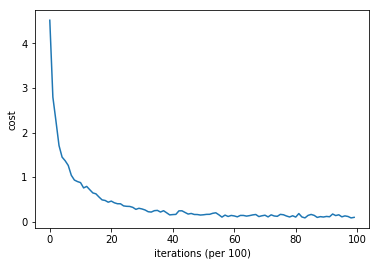

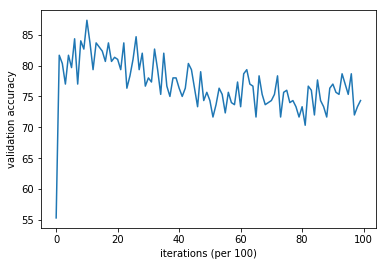

In [38]:
train_model()

In [39]:
    with open("costs_val_accs.pickle", "wb") as f:
        pickle.dump((costs,val_accs),f)

NameError: name 'costs' is not defined